# Meta-Learning with the Rank-Weighted GP Ensemble (RGPE)
Botorch is designed in to be model-agnostic and only requries that a model conform to a minimal interface. This tutorial walks through an example of implementing the rank-weighted Gaussian process ensemble (RGPE) [Feurer, Letham, Bakshy ICML 2018 AutoML Workshop] and using the RGPE in botorch to do meta-learning across related optimization tasks.

* Original paper: https://arxiv.org/pdf/1802.02219.pdf

In [1]:
import torch
import math

from torch import Tensor

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
torch.manual_seed(29)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

## Toy Problem
* We consider optimizing the following 1-D synthetic function
$$f(x, s_i) = \frac{1}{10}\bigg(x-1\bigg)\bigg(\sin(x+s_i)+\frac{1}{10}\bigg)$$
where
$$s_i = \frac{(i+9)\pi}{8}$$
is a task-dependent shift parameter and $i$ is the task index $i \in [1, t]$.

* In this tutorial, we will consider the scenario where we have collected data from 5 prior tasks (referred to as base tasks), which with a different task dependent shift parameter $s_i$.

* The goal now is use meta-learning to improve sample efficiency when optimizing a 6th task.

### Toy Problem Setup

First let's define a function for compute the shift parameter $s_i$ and set the shift amount for the target task.

In [3]:
NUM_BASE_TASKS = 5
def task_shift(task):
    """
    Fetch shift amount for task.
    """
    return math.pi * (task + 9) / 8.0
# set shift for target task
TARGET_SHIFT = math.pi

Then, let's define our function $f(x, s_i)$ and set bounds on $x$.

In [4]:
BOUNDS = torch.tensor([[-10.0], [10.0]], dtype=dtype, device=device)

def f(X: Tensor, shift: float = TARGET_SHIFT) -> Tensor:
    """
    Torch-compatible objective function for the target_task
    """
    f_X = 0.1*(X-1) * (torch.sin(X + shift) + 0.1)
    return f_X

### Sample training data for prior base tasks

We sample data from a Sobol sequence to help ensure numerical stability when using a small amount of 1-D data. Sobol sequences help prevent us from sampling a bunch of training points that are close together.

In [5]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
# Sample data for each base task
data_by_task = {}
for task in range(NUM_BASE_TASKS):
    num_training_points = torch.randint(low=15, high=26, size=(1,)).item()
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=num_training_points, q=1, seed=task+5397923).squeeze(1)    
    # get observed values
    f_x = f(raw_x, task_shift(task)).view(-1)
    train_y = f_x + 0.05*torch.randn_like(f_x)
    # store training data
    data_by_task[task] = {
        # scale x to [0, 1]
        'train_x': normalize(raw_x, bounds=BOUNDS),
        'train_y': train_y,
    }         

#### Let's plot the base tasks and the target task function along with the observed points

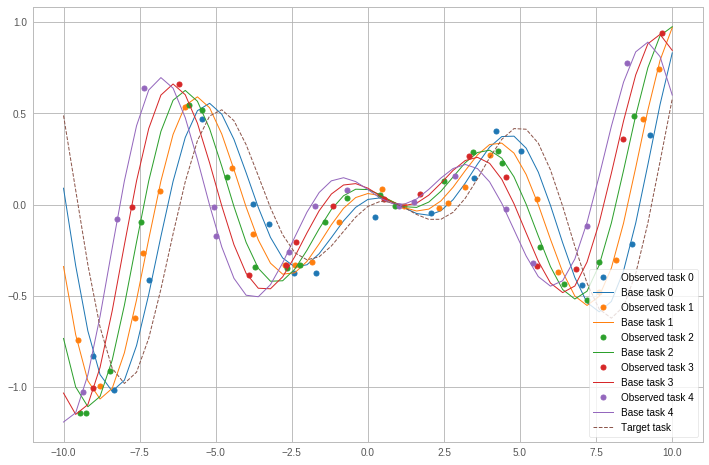

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = torch.linspace(-10,10,51)
for task in data_by_task:
    # plot true function and observed values for base runs
    t = ax.plot(
        unnormalize(data_by_task[task]['train_x'], bounds=BOUNDS).cpu().numpy(),
        data_by_task[task]['train_y'].cpu().numpy(),
        '.',
        markersize=10,
        label=f"Observed task {task}",
    )
    ax.plot(
        x.detach().numpy(),
        f(x, task_shift(task)).cpu().numpy(),
        label=f"Base task {task}",
        color=t[0].get_color(), 
    )
# plot true target function
ax.plot(
    x.detach().numpy(),
    f(x, TARGET_SHIFT).detach().numpy(),
    '--',
    label="Target task",

)
ax.legend(loc="lower right", fontsize=10)

### Fit base task models

First, let's define a helper function to fit a SingleTaskGP with an inferred noise level given training data.

In [7]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from botorch.fit import fit_gpytorch_model

def get_fitted_model(train_X: Tensor, train_Y: Tensor) -> SingleTaskGP:
    """
    Fit SingleTaskGP with torch.optim.Adam.
    """
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
    fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch, disp=False)
    return model

#### Now let's fit a SingleTaskGP for each base task

In [8]:
# Fit base model
base_model_list = []
for task in range(NUM_BASE_TASKS):
    print(f"Fitting base model {task}")
    model = get_fitted_model(data_by_task[task]['train_x'], data_by_task[task]['train_y'])
    base_model_list.append(model)  

Fitting base model 0
Fitting base model 1
Fitting base model 2
Fitting base model 3
Fitting base model 4


### Implement the RGPE

The main idea of the RGPE is to estimate the target function as weighted sum of the target model and the base models:
$$\bar f(\mathbf x | \mathcal D) =
\sum_{i=1}^{t} w_if^i(\mathbf x |\mathcal D_i)$$
Importantly, the ensemble model is also a GP:
$$\bar f(\mathbf x | \mathcal D) \sim \mathcal N\bigg(\sum_{i=1}^{t} w_i\mu_i(\mathbf x), \sum_{i=1}^{t}w_i^2\sigma_i^2\bigg)$$

The weights $w_i$ for model $i$ are based on the the ranking loss between a draw from the model's posterior and the targets. Specifically, the ranking loss for model $i$ is:
$$\mathcal L(f^i, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^i\big(\mathbf x^t_j\big) < f^i\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $\oplus$ is exclusive-or.

The loss for the target model is computing using leave-one-out cross-validation (LOOCV) and is given by:
$$\mathcal L(f^t, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^t_{-j}\big(\mathbf x^t_j\big) < f^t_{-j}\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $f^t_{-j}$ model fitted to all data from the target task except training example $j$.

The weights are then computed as:
$$w_i = \frac{1}{S}\sum_{s=1}^S\mathbb 1\big(i = \text{argmin}_{i'}l_{i', s}\big)$$

In [9]:
def roll_col(X: Tensor, shift: int) -> Tensor:  
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[:, -shift:], X[:, :-shift]), dim=1)


In [10]:
def compute_ranking_loss(f_samps: Tensor, target_y: Tensor) -> Tensor:
    """
    Compute ranking loss for each sample from the posterior over target points.
    
    Args:
        f_samps: `n_samples x n`-dim tensor of samples
        target_y: `n`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    y_stack = target_y.expand(f_samps.shape[0], *target_y.shape)
    rank_loss = torch.zeros(f_samps.shape[0], dtype=torch.long, device=target_y.device)
    for i in range(1,target_y.shape[0]):
        rank_loss += torch.sum(
            (roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack), 
            dim=1
        )
    return rank_loss


Defin a function to do use LOOCV to fit `n` independent GPs (using batch mode) and sample from their posterior at their respective test point. Note one deviation from the original paper is that the kernel hyperparameters are refit for each fold of the LOOCV, whereas the paper uses kernel hyperparameters from the original target model fit on all data points. 

Check out the [gpytorch batch mode fitting tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_Batch_Mode_GP_Regression.ipynb) for more info on batch mode GPs.

In [15]:
def get_target_model_loocv_sample_preds(train_x: Tensor, train_y: Tensor, num_samples: int) -> Tensor:
    """
    Use LOOCV to fit `b=n` independent GPs using batch mode and sample from
        their independent posteriors.
    
    Args:
        train_x: `n x d` tensor of training points
        train_y: `n` tensor of training targets
        num_sample: number of mc samples to draw
    
    Return: `num_samples x n`-dim tensor of samples for each target point from the corresponding GP
        (which was training without that point).
    """
    train_x = train_x.view(-1, 1)
    train_y = train_y.view(-1)
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8)
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    test_x_cv = torch.stack([train_x[m] for m in masks])
    test_y_cv = torch.stack([train_y[m] for m in masks])
    model = get_fitted_model(train_x_cv, train_y_cv)
    with torch.no_grad():
        # test_x_cv here is `n (batch dimension) x 1 (num points) x 1 (num dimensions)`.
        posterior = model.posterior(test_x_cv)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x 1 x 1`, so let's squeeze
        # the last two dimensions.
        return posterior.sample(sample_shape=torch.Size((num_samples,))).squeeze(-1).squeeze(-1)
    

In [16]:
from typing import List

def compute_rank_weights(
    train_x: Tensor, 
    train_y: Tensor, 
    base_models: List[SingleTaskGP], 
    num_samples: int
) -> Tensor:
    """
    Compute ranking weights for each base model and the target model (using 
        LOOCV for the target model). Note: This implementation does not currently 
        address weight dilution, since we only have a small number of base models.
    
    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of `n_t` base models
        num_samples: number of mc samples
    
    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        f_samps = posterior.sample(sample_shape=torch.Size((num_samples,))).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    f_samps = get_target_model_loocv_sample_preds(train_x, train_y, num_samples)
    ranking_losses.append(compute_ranking_loss(f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)/num_samples
    return rank_weights
        

In [17]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList

class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an 
        interface for GPyTorch models in botorch.
    """
    def __init__(self, models: List[SingleTaskGP], weights: Tensor) -> None:
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(dtype=weights.dtype, device=weights.device)
    
    @property
    def num_outputs(self) -> int:
        return 1
        
    def forward(self, x: Tensor) -> MultivariateNormal:
        # compute posterior for each model
        posteriors = [model.posterior(x) for model in self.models]
        weighted_means = []
        weighted_covars = []
        
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()
        
        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            posterior = posteriors[raw_idx]
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior.mean.squeeze(-1))
            # Use lazy covariance matrix
            weighted_covars.append(posterior.mvn.lazy_covariance_matrix * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.sum(torch.stack(weighted_means), dim=0)
        covar_x = gpytorch.lazy.PsdSumLazyTensor(*weighted_covars)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    

## Optimize target function using RGPE + mc-based qEI

In [18]:
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.sampler import SobolQMCNormalSampler
from botorch.optim.optimize import joint_optimize
import pandas as pd

best_rgpe_all = []
best_random_all = []
best_vanilla_ei_all = []
N_BATCH = 5
INNER_OPTIMIZER_LOOPS = 15
NUM_POSTERIOR_SAMPLES = 10
RANDOM_INITIALIZATION_SIZE = 4
N_TRIALS = 20
# N_TRIALS = 1
MC_SAMPLES = 1000
N_RESTART_CANDIDATES = 100
N_RESTARTS = 5
Q_BATCH_SIZE=1
# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_rgpe = []
    best_random = [] 
    best_vanilla_ei = []
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=trial).squeeze(1)    
    train_x = normalize(raw_x, bounds=BOUNDS)
    train_y = f(train_x)
    vanilla_ei_train_x = train_x.clone()
    vanilla_ei_train_y = train_y.clone()
    # keep track of the best observed point at each iteration
    best_value = train_y.max().item()
    best_rgpe.append(best_value)
    best_random.append(best_value)
    vanilla_ei_best_value = best_value
    best_vanilla_ei.append(vanilla_ei_best_value)


    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH): 
        target_model = get_fitted_model(train_x, train_y.view(-1))
        model_list = base_model_list + [target_model]
        rank_weights = compute_rank_weights(train_x, train_y.view(-1), base_model_list, NUM_POSTERIOR_SAMPLES)
        rgpe_model = RGPE(model_list, rank_weights)
        sampler_qei = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qEI = qExpectedImprovement(model=model, best_f=best_value)
        candidate = joint_optimize(
            acq_function=qEI,
            bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
            options={"seed": torch.randint(1, 100000, (1,)).item()},
        )

        # fetch the new values 
        new_x = candidate.detach()
        new_y = f(unnormalize(new_x, bounds=BOUNDS))

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        random_candidate = torch.rand(1, dtype=dtype, device=device)
        next_random_best = f(unnormalize(random_candidate, bounds=BOUNDS)).max().item()
        best_random.append(max(best_random[-1], next_random_best))

        # get the new best observed value
        best_value = train_y.max().item()
        best_rgpe.append(best_value)

        # Run Vanilla EI for comparison
        vanilla_ei_model = get_fitted_model(vanilla_ei_train_x, vanilla_ei_train_y.view(-1))
        vanilla_ei_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        vanilla_qEI = qExpectedImprovement(
            model=vanilla_ei_model, 
            best_f=vanilla_ei_best_value, 
            sampler=vanilla_ei_sampler,
        )
        vanilla_ei_candidate = joint_optimize(
            acq_function=vanilla_qEI,
            bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
            options={"seed": torch.randint(1, 100000, (1,)).item()},
        )
        # fetch the new values 
        vanilla_ei_new_x = vanilla_ei_candidate.detach()
        vanilla_ei_new_y = f(unnormalize(vanilla_ei_new_x, bounds=BOUNDS))

        # update training points
        vanilla_ei_train_x = torch.cat((vanilla_ei_train_x, vanilla_ei_new_x))
        vanilla_ei_train_y = torch.cat((vanilla_ei_train_y, vanilla_ei_new_y))

        # get the new best observed value
        vanilla_ei_best_value = vanilla_ei_train_y.max().item()
        best_vanilla_ei.append(vanilla_ei_best_value)
    best_rgpe_all.append(best_rgpe)
    best_random_all.append(best_random)
    best_vanilla_ei_all.append(best_vanilla_ei)
    

Trial 1 of 20
Trial 2 of 20
Trial 3 of 20
Trial 4 of 20
Trial 5 of 20
Trial 6 of 20
Trial 7 of 20
Trial 8 of 20
Trial 9 of 20
Trial 10 of 20
Trial 11 of 20
Trial 12 of 20
Trial 13 of 20
Trial 14 of 20
Trial 15 of 20
Trial 16 of 20
Trial 17 of 20
Trial 18 of 20
Trial 19 of 20
Trial 20 of 20


### Plot best observed value vs iteration

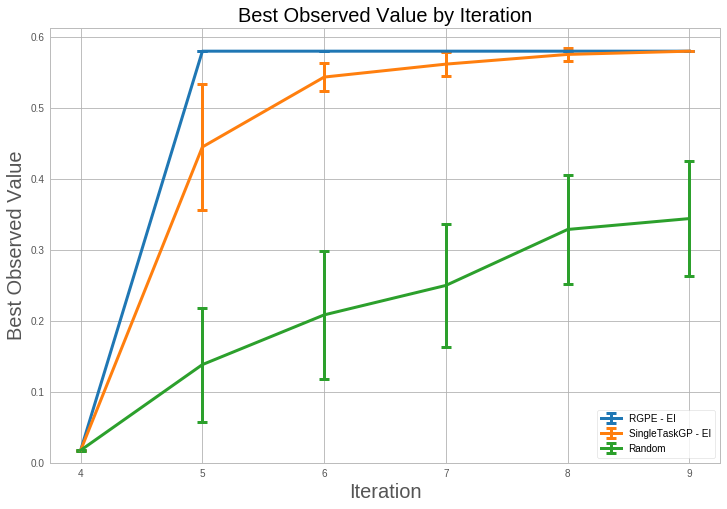

In [19]:
best_rgpe_all = torch.tensor(best_rgpe_all, dtype=dtype, device=device)
best_random_all = torch.tensor(best_random_all, dtype=dtype, device=device)
best_vanilla_ei_all = torch.tensor(best_vanilla_ei_all, dtype=dtype, device=device)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fontdict = {"size": 20}
x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH + 1)
# Plot RGPE - EI
ax.errorbar(
    x, 
    best_rgpe_all.mean(dim=0).cpu().numpy(), 
    yerr=(1.96*best_rgpe_all.std(dim=0)/math.sqrt(N_TRIALS)).cpu().numpy(), 
    label="RGPE - EI", 
    linewidth=3, 
    capsize=5,
    capthick=3,
)
# Plot SingleTaskGP - EI
ax.errorbar(
    x, 
   best_vanilla_ei_all.mean(dim=0).cpu().numpy(), 
    yerr=(1.96*best_vanilla_ei_all.std(dim=0)/math.sqrt(N_TRIALS)).cpu().numpy(), 
    label="SingleTaskGP - EI", 
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot Random
ax.errorbar(
    x, 
    best_random_all.mean(dim=0).cpu().numpy(), 
    yerr=(1.96*best_random_all.std(dim=0)/math.sqrt(N_TRIALS)).cpu().numpy(), 
    label="Random", 
    linewidth=3,
    capsize=5,
    capthick=3,
)
ax.set_ylim(bottom=0)
ax.set_xlabel('Iteration', fontdict=fontdict)
ax.set_ylabel('Best Observed Value', fontdict=fontdict)
ax.set_title('Best Observed Value by Iteration', fontdict=fontdict)
ax.legend(loc="lower right", fontsize=10)